Change Log:
- v31 - 3 groups
- v30 - binary second run, without dt_diff, using correct parameters
- v23 - build two model for each price group, limit the training set to each target price group
- v20 - lower learning rate = 0.0008, add height_r and top_floor index
- v16 - change parameters (some from model 05), rm reduce to 68
- v14 - change random seed
- v10 - remove features based on feature importance results (exp-l04-per-area)

### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import cal_mape

from utilities import cal_score, convert_types, create_dt_feats

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


In [2]:
model_name = 'model-31-lgb-3_groups'

### Params

In [3]:
is_log_target = True
is_per_area_target = True
is_duplicated_train = False

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]

#cols_feats_add = ['encoded_latlon', 'building_per_land_area'] # add feats into model
cols_num_add = ['building_per_land_area', 'height_r']
cols_cat_add = ['encoded_latlon']

#cols_feats_rm = [] # TODO: implement before using it
#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

### Processing

In [4]:
def pre_processing(df, cols_num, cols_cat): #, cols_feats
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['building_per_land_area'] = df['building_area'] / df['land_area']
 
    #cols_feats = cols_num + cols_cat + cols_feats_add
    
    # fix town and city
    df['town'] = df['city'].astype('str')+'-'+df['town'].astype('str')
    df['village'] = df['town'].astype('str')+'-'+df['village'].astype('str')
    
    # height ratio
    df['height_r'] = df['txn_floor'] / df['total_floor']
    df['top_floor'] = df['txn_floor'] == df['total_floor']
    
    return df  #, cols_feats

In [5]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding

class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_feats, col_target, n_ran_encode=4):
        # cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_feats = cols_feats
        self.col_target = col_target
        
        # Numbers
        self.n_ran_encode = n_ran_encode
        
        # encoders
        #self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.cat_astyper = CategoricalColumnsEncoder(mode='pandas')
        
    def fit_transform(self, df):
        df = df.copy()
    
#        encoded1 = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
#        encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        self.cat_astyper.fit_transform(df, self.cols_cat)    
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
#        encoded1 = self.tar_encoder.transform(df[self.cols_cat])
#        encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        self.cat_astyper.transform(df)
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)

In [6]:
def post_processing(y_pred, df):
    """Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area'].values
        
    return y_pred_final

### Columns

In [7]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor',
            'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area',
            'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate',
            'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate',
            'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250',
            'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500',
            'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500',
            'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500',
            'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000',
            'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000',
            'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000',
            'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000',
            'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000',
            'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN',
            'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10',
            'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10',
            'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN',
            'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village',
            'I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']
cols_feats = cols_num + cols_cat

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']

### Read data

In [8]:
train = pd.read_csv('dataset/train.csv', dtype=object)
test = pd.read_csv('dataset/test.csv', dtype=object)

id_cv = []
for i in range(5):
    id_one_fold = pd.read_csv(f'dataset/id_cv{i}.csv', dtype=object)['building_id']
    id_cv.append(id_one_fold)

In [9]:
train_group = pd.read_csv('output/model-19-lgb-search-bins-lr-0.0005-cv.csv')
test_group = pd.read_csv('output/model-19-lgb-search-bins-lr-0.0005-test-one.csv')

In [10]:
train['building_area'].check()

0        3.4181753419481464
1         4.041308798890836
2         5.584278851043925
3          13.5630307018626
4         4.688108411761061
59995     6.754059520927508
59996    5.3567878135940425
59997     8.223644006364365
59998     8.728286999877707
59999    5.3567878135940425
Name: building_area, dtype: object

shape = (60000,)


In [11]:
train_group = train_group.merge(train[['building_id', 'building_area']], on='building_id')
train_group['building_area'] = train_group['building_area'].astype('float32')
train_group = train_group.drop('total_price', axis=1).rename({'total_price_predict': 'total_price'}, axis=1)

test_group = test_group.merge(test[['building_id', 'building_area']], on='building_id')
test_group['building_area'] = test_group['building_area'].astype('float32')

train_group['price_per_area'] = train_group['total_price'] / train_group['building_area']
test_group['price_per_area'] = test_group['total_price'] / test_group['building_area']

In [12]:
sorted_price_per_area = sorted(train_group['price_per_area'])

In [13]:
group_split_1 = sorted_price_per_area[20000]
group_split_2 = sorted_price_per_area[40000]
print('split point:', group_split_1, group_split_2)

split point: 442597.0663635943 1171834.5181095994


In [14]:
# Assigne group index
train_group['price_group_pred'] = [0 if x < group_split_1 else (1 if x < group_split_2 else 2) for x in train_group['price_per_area']]
test_group['price_group_pred'] = [0 if x < group_split_1 else (1 if x < group_split_2 else 2) for x in test_group['price_per_area']]

In [15]:
train_group.check()

,building_id,total_price,building_area,price_per_area,price_group_pred
0,jre1pJhcQj91Kdky,1.272405e+07,13.563030,9.381421e+05,1
1,jcbuA8q3KPH9SzpS,9.475287e+06,12.446199,7.612996e+05,1
2,EqWJpHmkXPyfHkB8,4.653431e+06,3.830869,1.214719e+06,2
3,ihrMWGM8Nq99Uvu6,6.885630e+06,6.754059,1.019480e+06,1
4,jRhwzoVMFLFzxAX1,2.787730e+06,3.016963,9.240189e+05,1
59995,QZSvDBvS2WqfYPDl,2.591887e+07,4.688108,5.528642e+06,2
59996,JjHLg8Nh6k4Tbdci,3.747146e+07,17.341492,2.160798e+06,2
59997,PiOgZqfsDVlTq1zs,1.468696e+07,5.356788,2.741748e+06,2
59998,FQmlgGohzzWuKUzu,1.267313e+07,8.223644,1.541060e+06,2
59999,zjzfMwXhDswdEaI2,1.720550e+07,8.728287,1.971234e+06,2


shape = (60000, 5)


In [16]:
train_group['price_group_pred'].value_counts()

2    20000
1    20000
0    20000
Name: price_group_pred, dtype: int64

In [17]:
test_group['price_group_pred'].value_counts()

0    3415
2    3301
1    3284
Name: price_group_pred, dtype: int64

In [18]:
test_group.check()

,building_id,total_price,building_area,price_per_area,price_group_pred
0,X5gsdTWGS3W7JJQB,1.428857e+07,3.418175,4.180173e+06,2
1,BTshNOJyKHnT2YIT,3.911863e+06,7.726227,5.063096e+05,1
2,dhdymr0lV8N5kZOT,1.070213e+07,12.170581,8.793442e+05,1
3,VEwyGGMcD56w5BOc,6.009188e+06,2.252256,2.668075e+06,2
4,wmUeMoJZfsqaSX9b,1.086611e+06,5.813985,1.868961e+05,0
9995,UEeCDaAJzPwdKKKA,1.202268e+06,7.236278,1.661445e+05,0
9996,i0fgbPaQsDWs7Q87,4.753556e+07,13.001777,3.656082e+06,2
9997,YunNwAhcqkf6YclI,1.092241e+06,8.223644,1.328171e+05,0
9998,A2NotxtRY9MYoWMl,2.972358e+06,3.830869,7.758963e+05,1
9999,kKvgBXiA50gRmQhP,3.079109e+06,11.623768,2.648977e+05,0


shape = (10000, 5)


In [19]:
# Add price group predictions
#train_group = pd.read_csv('output/metamodel-03-lgb-binary-cv.csv')  # add price group
train = train.merge(train_group[['building_id', 'price_group_pred']], 
                    how='left', on='building_id')
assert not train['price_group_pred'].isnull().any()
train.check()

#test_group = pd.read_csv('output/metamodel-03-lgb-binary-test-one.csv')  # add price group using one
test = test.merge(test_group[['building_id', 'price_group_pred']], how='left', on='building_id')
assert not test['price_group_pred'].isnull().any()
test.check()

price_groups = sorted(train['price_group_pred'].unique())
print('Price groups:', 'N =', len(price_groups), price_groups)
#print('Binary classification accuracy (train):', 
#      '%.5f'%(train['price_group'] == train['price_group_pred']).mean())

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price,price_group_pred
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,1,157,1,2483,1,6011,1,34.469802848528126,647603.7704719775,0
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,1,115,1,15872,1,32221,1,40.07357348973039,3321452.0,1
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,1,212,1,15760,1,32228,1,54.46208108983661,9570885.316206373,2
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,1,125,1,2568,1,7271,1,99.62896580763416,14215011.127100045,1
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,1,47,1,2587,1,7442,1,124.1312362968124,762711.9757135696,0
59995,Oh5Hwr9LrWApC2mr,1,5,19040,2,4,2,9193,2,NaN,...,1,53,1,1435,1,4611,1,145.27967019169262,987021.4150420949,0
59996,PiOgZqfsDVlTq1zs,8,13,19706,14,2,5,17168,0,3.738411744735565,...,1,316,1,5659,1,22826,1,18.81499793345573,15725223.997450478,2
59997,FQmlgGohzzWuKUzu,8,7,19901,11,0,2,13729,0,NaN,...,1,348,1,13252,1,32687,1,94.79959334423607,11815402.03862225,2
59998,zjzfMwXhDswdEaI2,8,13,19975,5,1,2,7063,2,NaN,...,1,142,1,5317,1,21087,1,33.10458025153816,18084995.81999832,2
59999,iN4H6wBMtvJpF0SN,8,7,20385,5,1,2,8310,2,NaN,...,1,249,1,15417,1,32826,1,47.50987600102272,8510295.87633061,2


shape = (60000, 236)


,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,price_group_pred
0,X5gsdTWGS3W7JJQB,1,13,18634,2,4,2,1857,2,NaN,...,21,1,129,1,3991,1,8409,1,105.4622312795739,2
1,BTshNOJyKHnT2YIT,8,7,20199,10,3,2,16011,2,NaN,...,44,1,67,1,1950,1,10725,1,100.81980868401074,1
2,dhdymr0lV8N5kZOT,8,12,19769,4,4,10,18294,2,NaN,...,3,1,35,1,3707,1,19459,1,259.8005430183116,1
3,VEwyGGMcD56w5BOc,10,7,20479,19,2,0,17837,2,NaN,...,60,1,144,1,6487,1,29400,1,22.941906168328487,2
4,wmUeMoJZfsqaSX9b,8,3,18164,13,0,2,13272,2,NaN,...,18,1,76,1,1346,1,3280,1,181.21309507601745,0
9995,UEeCDaAJzPwdKKKA,8,3,19494,6,3,2,12115,2,NaN,...,5,1,35,1,1118,1,3408,1,276.63801953982124,0
9996,i0fgbPaQsDWs7Q87,8,13,19166,13,0,2,17502,0,8.654350043224781,...,23,1,66,1,3773,1,16164,1,46.55561753672866,2
9997,YunNwAhcqkf6YclI,8,5,19340,3,4,2,11324,2,NaN,...,7,1,42,1,1354,1,5693,1,13.622703036125506,0
9998,A2NotxtRY9MYoWMl,8,7,18184,5,1,2,7885,2,NaN,...,182,1,840,1,6469,1,31383,1,91.48925980597359,1
9999,kKvgBXiA50gRmQhP,8,21,20370,6,3,2,11142,2,NaN,...,26,1,119,1,3769,1,9529,1,124.55299965753014,0


shape = (10000, 235)
Price groups: N = 3 [0, 1, 2]


### Preprocessing

In [20]:
train = pre_processing(train, cols_num, cols_cat)
test = pre_processing(test, cols_num, cols_cat)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [21]:
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_feats = cols_num + cols_cat

### Remove feats based on shuffle results

In [22]:
# PARS #
N_feats_rm = 68
# PARS #

from vars_03 import score_base_per_area, shuffle_results_per_area

feat_imp = pd.DataFrame({'feats': shuffle_results_per_area[:,0],
                         'avg':shuffle_results_per_area[:,1]})
feat_imp['diff'] = feat_imp['avg'] - score_base_per_area
feat_imp = feat_imp.sort_values(by='diff', ascending=False)
print(feat_imp.reset_index().values)

feats_rm = list(feat_imp.iloc[:(N_feats_rm+1)]['feats'].values)
#feats_rm.remove('none')
print(len(feats_rm))
print(feats_rm)

print('N feats (before):', len(cols_feats))
cols_feats = list(set(cols_feats) - set(feats_rm))
print('N feats (after):', len(cols_feats))
print(cols_feats)

[[0 'divorce_rate' 5709.20035 3.333296666667593]
 [1 'I_250' 5709.200316666666 3.333263333333889]
 [2 'XI_100' 5708.200346666667 2.33329333333495]
 [3 'VI_index_500' 5707.867050000001 1.9999966666682667]
 [4 'IX_index_50' 5707.86704 1.9999866666676098]
 [5 'VI_500' 5707.866983333333 1.9999300000008589]
 [6 'XIV_10' 5707.533710000001 1.666656666668132]
 [7 'XI_index_500' 5707.200386666666 1.3333333333339397]
 [8 'VI_index_1000' 5707.200383333334 1.3333300000012969]
 [9 'V_100' 5707.200373333333 1.33332000000064]
 [10 'VII_10' 5707.200363333334 1.333310000001802]
 [11 'X_100' 5707.200336666666 1.3332833333333838]
 [12 'XII_index_50' 5706.867056666667 1.0000033333344618]
 [15 'X_index_500' 5706.867050000001 0.9999966666682667]
 [14 'X_10' 5706.867050000001 0.9999966666682667]
 [13 'II_10' 5706.867050000001 0.9999966666682667]
 [16 'II_index_500' 5706.867046666666 0.9999933333338049]
 [17 'V_index_1000' 5706.867046666666 0.9999933333338049]
 [18 'XIII_10' 5706.867043333335 0.99999000000207

### Params

In [23]:
# params
# parameters from model 10: 24, 300, 0.5, 10, 0.1, 0.0
# parameters from model 5: 24, 258, 0.4, 6, 0.04, 0.02
params = {'task': 'train',
          'boosting_type': 'gbdt',
          'objective': 'mse',
          'metric': 'mape',
          'learning_rate': 0.0005, # 0.001
          'max_depth': 23,
          'num_leaves': 85,           # may reduce in dim-reduction exp
          'feature_fraction': 0.4,
          'min_data_in_leaf': 4,
          'lambda_l1': 0.01,
          'lambda_l2': 0.01,
          'max_bin': 255,
          'min_sum_hessian_in_leaf': 0.001,
          'min_data_per_group': 7,
          'seed': 555,
         }

lgb_other_params = {'num_boost_round': 1000000,  # expected to stop 250000
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000,
                    'keep_training_booster': True,
                   }


### kfold cross-predict

In [24]:
t0 = time.time()

predicts_val = []
predicts_test = test[['building_id']].copy()
best_iterations = []
scores = []; mapes = []
for i, id_fold in enumerate(id_cv):
    #id_fold = id_fold['building_id']
    # split train, val
    df_train = train.loc[~train['building_id'].isin(id_fold)].copy()
    df_val = train.loc[train['building_id'].isin(id_fold)].copy()
    df_test = test.copy()
    
    # feat eng
    feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
    df_train = feat_eng.fit_transform(df_train)
    df_val = feat_eng.transform(df_val)
    df_test = feat_eng.transform(df_test)
    
    # split price group
    best_iters = []
    for pg in price_groups:
        df_train_g = df_train.loc[df_train['price_group_pred'] == pg]
        df_val_g = df_val.loc[df_val['price_group_pred'] == pg]

        if is_duplicated_train:
            df_train_g = pd.concat([df_train_g, df_train], ignore_index=True)
        
        # Construct lgb dataset
        lgb_train = lgb.Dataset(df_train_g[cols_feats], df_train_g[col_target]).construct()
        lgb_val = lgb.Dataset(df_val_g[cols_feats], df_val_g[col_target], reference=lgb_train).construct()
        
        # train model    
        model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)
        best_iters.append(model.best_iteration)

        # Predict on val set
        val_pg_mask = df_val['price_group_pred'] == pg
        df_val.loc[val_pg_mask, col_target+'_pred'] = (
            model.predict(df_val.loc[val_pg_mask, cols_feats])
        )
        
        # Predict on test set
        test_pg_mask = df_test['price_group_pred'] == pg
        predicts_test.loc[test_pg_mask, 'target_{}'.format(i)] = (
            model.predict(df_test.loc[test_pg_mask, cols_feats])
        )
    
    mse = mean_squared_error(df_val[col_target], df_val[col_target+'_pred'])
    mae = mean_absolute_error(df_val[col_target], df_val[col_target+'_pred'])
    mape = cal_mape(df_val[col_target], df_val[col_target+'_pred'])
    mapes.append(mape)
    
    y_pred_final = post_processing(df_val[col_target+'_pred'], df_val)
    score = cal_score(df_val['total_price'], y_pred_final)
    scores.append(score)
    best_iterations.append(best_iters)

    print('(Fold %d) score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f.' % (i, score, mse, mae, mape))
    predicts_val.append(pd.DataFrame({'building_id': df_val['building_id'],
                                      'total_price': df_val['total_price'],
                                      'total_price_predict': y_pred_final}))

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0203746
[4000]	valid_0's mape: 0.0170708
[6000]	valid_0's mape: 0.0155488
[8000]	valid_0's mape: 0.0146787
[10000]	valid_0's mape: 0.0141335
[12000]	valid_0's mape: 0.0137568
[14000]	valid_0's mape: 0.0134891
[16000]	valid_0's mape: 0.0132886
[18000]	valid_0's mape: 0.0131306
[20000]	valid_0's mape: 0.0130032
[22000]	valid_0's mape: 0.0128943
[24000]	valid_0's mape: 0.0128048
[26000]	valid_0's mape: 0.0127277
[28000]	valid_0's mape: 0.01266
[30000]	valid_0's mape: 0.0125999
[32000]	valid_0's mape: 0.0125485
[34000]	valid_0's mape: 0.0125021
[36000]	valid_0's mape: 0.0124593
[38000]	valid_0's mape: 0.0124216
[40000]	valid_0's mape: 0.0123875
[42000]	valid_0's mape: 0.0123568
[44000]	valid_0's mape: 0.0123295
[46000]	valid_0's mape: 0.0123048
[48000]	valid_0's mape: 0.0122816
[50000]	valid_0's mape: 0.0122605
[52000]	valid_0's mape: 0.0122406
[54000]	valid_0's mape: 0.0122227
[56000]	valid_0's mape: 

[472000]	valid_0's mape: 0.011884
[474000]	valid_0's mape: 0.0118839
[476000]	valid_0's mape: 0.0118839
[478000]	valid_0's mape: 0.0118838
[480000]	valid_0's mape: 0.0118838
[482000]	valid_0's mape: 0.0118837
[484000]	valid_0's mape: 0.0118836
[486000]	valid_0's mape: 0.0118836
[488000]	valid_0's mape: 0.0118835
[490000]	valid_0's mape: 0.0118835
[492000]	valid_0's mape: 0.0118834
[494000]	valid_0's mape: 0.0118833
[496000]	valid_0's mape: 0.0118833
[498000]	valid_0's mape: 0.0118832
[500000]	valid_0's mape: 0.0118832
[502000]	valid_0's mape: 0.0118831
[504000]	valid_0's mape: 0.0118831
[506000]	valid_0's mape: 0.011883
[508000]	valid_0's mape: 0.011883
[510000]	valid_0's mape: 0.011883
[512000]	valid_0's mape: 0.0118829
[514000]	valid_0's mape: 0.0118828
[516000]	valid_0's mape: 0.0118828
[518000]	valid_0's mape: 0.0118827
[520000]	valid_0's mape: 0.0118827
[522000]	valid_0's mape: 0.0118827
[524000]	valid_0's mape: 0.0118826
[526000]	valid_0's mape: 0.0118826
[528000]	valid_0's mape:

[300000]	valid_0's mape: 0.00911123
[302000]	valid_0's mape: 0.00911108
[304000]	valid_0's mape: 0.00911089
[306000]	valid_0's mape: 0.00911071
[308000]	valid_0's mape: 0.00911052
[310000]	valid_0's mape: 0.00911037
[312000]	valid_0's mape: 0.0091102
[314000]	valid_0's mape: 0.00911004
[316000]	valid_0's mape: 0.00910988
[318000]	valid_0's mape: 0.0091097
[320000]	valid_0's mape: 0.00910954
[322000]	valid_0's mape: 0.00910937
[324000]	valid_0's mape: 0.0091092
[326000]	valid_0's mape: 0.00910901
[328000]	valid_0's mape: 0.00910885
[330000]	valid_0's mape: 0.00910869
[332000]	valid_0's mape: 0.00910853
[334000]	valid_0's mape: 0.00910839
[336000]	valid_0's mape: 0.00910826
[338000]	valid_0's mape: 0.0091081
[340000]	valid_0's mape: 0.00910796
[342000]	valid_0's mape: 0.00910782
[344000]	valid_0's mape: 0.00910773
[346000]	valid_0's mape: 0.00910761
[348000]	valid_0's mape: 0.00910747
[350000]	valid_0's mape: 0.00910732
[352000]	valid_0's mape: 0.00910721
[354000]	valid_0's mape: 0.00910

[138000]	valid_0's mape: 0.00716435
[140000]	valid_0's mape: 0.0071624
[142000]	valid_0's mape: 0.00716063
[144000]	valid_0's mape: 0.00715889
[146000]	valid_0's mape: 0.00715718
[148000]	valid_0's mape: 0.00715556
[150000]	valid_0's mape: 0.00715399
[152000]	valid_0's mape: 0.00715247
[154000]	valid_0's mape: 0.00715105
[156000]	valid_0's mape: 0.0071497
[158000]	valid_0's mape: 0.00714839
[160000]	valid_0's mape: 0.00714714
[162000]	valid_0's mape: 0.00714585
[164000]	valid_0's mape: 0.00714473
[166000]	valid_0's mape: 0.00714363
[168000]	valid_0's mape: 0.00714275
[170000]	valid_0's mape: 0.0071418
[172000]	valid_0's mape: 0.00714078
[174000]	valid_0's mape: 0.00713985
[176000]	valid_0's mape: 0.00713899
[178000]	valid_0's mape: 0.00713806
[180000]	valid_0's mape: 0.00713717
[182000]	valid_0's mape: 0.00713624
[184000]	valid_0's mape: 0.00713537
[186000]	valid_0's mape: 0.00713454
[188000]	valid_0's mape: 0.00713366
[190000]	valid_0's mape: 0.00713278
[192000]	valid_0's mape: 0.0071

[596000]	valid_0's mape: 0.00709691
[598000]	valid_0's mape: 0.00709689
[600000]	valid_0's mape: 0.00709688
[602000]	valid_0's mape: 0.00709686
[604000]	valid_0's mape: 0.00709684
[606000]	valid_0's mape: 0.00709682
[608000]	valid_0's mape: 0.00709681
[610000]	valid_0's mape: 0.0070968
[612000]	valid_0's mape: 0.00709678
[614000]	valid_0's mape: 0.00709676
[616000]	valid_0's mape: 0.00709674
Early stopping, best iteration is:
[616141]	valid_0's mape: 0.00709674
(Fold 0) score, mse, mae, mape: 5732.87150, 0.03816, 0.12469, 0.00937.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0199128
[4000]	valid_0's mape: 0.0168236
[6000]	valid_0's mape: 0.0153776
[8000]	valid_0's mape: 0.0145642
[10000]	valid_0's mape: 0.0140577
[12000]	valid_0's mape: 0.0137181
[14000]	valid_0's mape: 0.0134855
[16000]	valid_0's mape: 0.0133132
[18000]	valid_0's mape: 0.013178
[20000]	valid_0's mape: 0.0130698
[22000]	valid_0's mape: 0.0129807
[24000]	valid_0's mape: 0.0129

[442000]	valid_0's mape: 0.0120194
[444000]	valid_0's mape: 0.0120193
[446000]	valid_0's mape: 0.0120192
[448000]	valid_0's mape: 0.0120191
[450000]	valid_0's mape: 0.0120191
[452000]	valid_0's mape: 0.012019
[454000]	valid_0's mape: 0.012019
[456000]	valid_0's mape: 0.0120189
[458000]	valid_0's mape: 0.0120188
[460000]	valid_0's mape: 0.0120187
[462000]	valid_0's mape: 0.0120187
[464000]	valid_0's mape: 0.0120186
[466000]	valid_0's mape: 0.0120185
[468000]	valid_0's mape: 0.0120185
[470000]	valid_0's mape: 0.0120184
[472000]	valid_0's mape: 0.0120184
[474000]	valid_0's mape: 0.0120183
[476000]	valid_0's mape: 0.0120182
[478000]	valid_0's mape: 0.0120182
[480000]	valid_0's mape: 0.0120181
[482000]	valid_0's mape: 0.0120181
[484000]	valid_0's mape: 0.012018
[486000]	valid_0's mape: 0.012018
[488000]	valid_0's mape: 0.0120179
[490000]	valid_0's mape: 0.0120179
[492000]	valid_0's mape: 0.0120178
[494000]	valid_0's mape: 0.0120178
[496000]	valid_0's mape: 0.0120178
[498000]	valid_0's mape:

[266000]	valid_0's mape: 0.00924088
[268000]	valid_0's mape: 0.00924053
[270000]	valid_0's mape: 0.00924024
[272000]	valid_0's mape: 0.00923996
[274000]	valid_0's mape: 0.00923971
[276000]	valid_0's mape: 0.0092395
[278000]	valid_0's mape: 0.00923925
[280000]	valid_0's mape: 0.00923897
[282000]	valid_0's mape: 0.00923867
[284000]	valid_0's mape: 0.00923842
[286000]	valid_0's mape: 0.00923816
[288000]	valid_0's mape: 0.00923789
[290000]	valid_0's mape: 0.00923765
[292000]	valid_0's mape: 0.0092374
[294000]	valid_0's mape: 0.00923718
[296000]	valid_0's mape: 0.00923697
[298000]	valid_0's mape: 0.00923676
[300000]	valid_0's mape: 0.00923647
[302000]	valid_0's mape: 0.00923621
[304000]	valid_0's mape: 0.009236
[306000]	valid_0's mape: 0.00923579
[308000]	valid_0's mape: 0.00923557
[310000]	valid_0's mape: 0.00923534
[312000]	valid_0's mape: 0.00923513
[314000]	valid_0's mape: 0.0092349
[316000]	valid_0's mape: 0.00923468
[318000]	valid_0's mape: 0.00923449
[320000]	valid_0's mape: 0.009234

[118000]	valid_0's mape: 0.00730809
[120000]	valid_0's mape: 0.00730583
[122000]	valid_0's mape: 0.0073036
[124000]	valid_0's mape: 0.00730143
[126000]	valid_0's mape: 0.00729945
[128000]	valid_0's mape: 0.00729768
[130000]	valid_0's mape: 0.00729598
[132000]	valid_0's mape: 0.00729426
[134000]	valid_0's mape: 0.00729253
[136000]	valid_0's mape: 0.00729098
[138000]	valid_0's mape: 0.00728943
[140000]	valid_0's mape: 0.00728805
[142000]	valid_0's mape: 0.00728667
[144000]	valid_0's mape: 0.00728534
[146000]	valid_0's mape: 0.00728418
[148000]	valid_0's mape: 0.00728293
[150000]	valid_0's mape: 0.00728175
[152000]	valid_0's mape: 0.00728064
[154000]	valid_0's mape: 0.00727958
[156000]	valid_0's mape: 0.00727848
[158000]	valid_0's mape: 0.00727753
[160000]	valid_0's mape: 0.00727648
[162000]	valid_0's mape: 0.00727551
[164000]	valid_0's mape: 0.00727453
[166000]	valid_0's mape: 0.00727362
[168000]	valid_0's mape: 0.00727267
[170000]	valid_0's mape: 0.00727183
[172000]	valid_0's mape: 0.00

[576000]	valid_0's mape: 0.00723502
[578000]	valid_0's mape: 0.00723501
[580000]	valid_0's mape: 0.007235
[582000]	valid_0's mape: 0.007235
[584000]	valid_0's mape: 0.00723499
[586000]	valid_0's mape: 0.00723498
[588000]	valid_0's mape: 0.00723497
[590000]	valid_0's mape: 0.00723496
[592000]	valid_0's mape: 0.00723495
[594000]	valid_0's mape: 0.00723494
[596000]	valid_0's mape: 0.00723493
[598000]	valid_0's mape: 0.00723492
Early stopping, best iteration is:
[598479]	valid_0's mape: 0.00723492
(Fold 1) score, mse, mae, mape: 5834.86973, 0.04163, 0.12623, 0.00947.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0198388
[4000]	valid_0's mape: 0.0166741
[6000]	valid_0's mape: 0.0151639
[8000]	valid_0's mape: 0.014341
[10000]	valid_0's mape: 0.0138186
[12000]	valid_0's mape: 0.0134592
[14000]	valid_0's mape: 0.0132092
[16000]	valid_0's mape: 0.0130222
[18000]	valid_0's mape: 0.0128739
[20000]	valid_0's mape: 0.0127582
[22000]	valid_0's mape: 0.01266

[440000]	valid_0's mape: 0.0116076
[442000]	valid_0's mape: 0.0116075
[444000]	valid_0's mape: 0.0116074
[446000]	valid_0's mape: 0.0116073
[448000]	valid_0's mape: 0.0116072
[450000]	valid_0's mape: 0.0116071
[452000]	valid_0's mape: 0.0116071
[454000]	valid_0's mape: 0.011607
[456000]	valid_0's mape: 0.0116069
[458000]	valid_0's mape: 0.0116068
[460000]	valid_0's mape: 0.0116067
[462000]	valid_0's mape: 0.0116066
[464000]	valid_0's mape: 0.0116066
[466000]	valid_0's mape: 0.0116065
[468000]	valid_0's mape: 0.0116064
[470000]	valid_0's mape: 0.0116063
[472000]	valid_0's mape: 0.0116062
[474000]	valid_0's mape: 0.0116062
[476000]	valid_0's mape: 0.0116061
[478000]	valid_0's mape: 0.011606
[480000]	valid_0's mape: 0.011606
[482000]	valid_0's mape: 0.0116059
[484000]	valid_0's mape: 0.0116058
[486000]	valid_0's mape: 0.0116057
[488000]	valid_0's mape: 0.0116057
[490000]	valid_0's mape: 0.0116056
[492000]	valid_0's mape: 0.0116056
[494000]	valid_0's mape: 0.0116055
[496000]	valid_0's mape

[246000]	valid_0's mape: 0.00951716
[248000]	valid_0's mape: 0.00951671
[250000]	valid_0's mape: 0.00951633
[252000]	valid_0's mape: 0.00951601
[254000]	valid_0's mape: 0.0095157
[256000]	valid_0's mape: 0.00951536
[258000]	valid_0's mape: 0.00951505
[260000]	valid_0's mape: 0.00951475
[262000]	valid_0's mape: 0.00951443
[264000]	valid_0's mape: 0.00951415
[266000]	valid_0's mape: 0.00951387
[268000]	valid_0's mape: 0.00951358
[270000]	valid_0's mape: 0.00951333
[272000]	valid_0's mape: 0.00951306
[274000]	valid_0's mape: 0.00951278
[276000]	valid_0's mape: 0.00951253
[278000]	valid_0's mape: 0.00951228
[280000]	valid_0's mape: 0.00951204
[282000]	valid_0's mape: 0.00951182
[284000]	valid_0's mape: 0.0095116
[286000]	valid_0's mape: 0.00951133
[288000]	valid_0's mape: 0.00951108
[290000]	valid_0's mape: 0.00951086
[292000]	valid_0's mape: 0.00951064
[294000]	valid_0's mape: 0.00951042
[296000]	valid_0's mape: 0.00951025
[298000]	valid_0's mape: 0.00951004
[300000]	valid_0's mape: 0.009

[86000]	valid_0's mape: 0.00735632
[88000]	valid_0's mape: 0.00735215
[90000]	valid_0's mape: 0.00734822
[92000]	valid_0's mape: 0.0073444
[94000]	valid_0's mape: 0.00734093
[96000]	valid_0's mape: 0.00733734
[98000]	valid_0's mape: 0.00733404
[100000]	valid_0's mape: 0.00733068
[102000]	valid_0's mape: 0.00732766
[104000]	valid_0's mape: 0.00732477
[106000]	valid_0's mape: 0.00732204
[108000]	valid_0's mape: 0.00731931
[110000]	valid_0's mape: 0.00731666
[112000]	valid_0's mape: 0.00731415
[114000]	valid_0's mape: 0.00731171
[116000]	valid_0's mape: 0.00730957
[118000]	valid_0's mape: 0.00730737
[120000]	valid_0's mape: 0.00730511
[122000]	valid_0's mape: 0.00730311
[124000]	valid_0's mape: 0.00730122
[126000]	valid_0's mape: 0.00729948
[128000]	valid_0's mape: 0.00729795
[130000]	valid_0's mape: 0.00729625
[132000]	valid_0's mape: 0.00729459
[134000]	valid_0's mape: 0.00729287
[136000]	valid_0's mape: 0.00729119
[138000]	valid_0's mape: 0.00728961
[140000]	valid_0's mape: 0.00728793


[544000]	valid_0's mape: 0.00722716
[546000]	valid_0's mape: 0.00722713
[548000]	valid_0's mape: 0.00722711
[550000]	valid_0's mape: 0.00722709
[552000]	valid_0's mape: 0.00722706
[554000]	valid_0's mape: 0.00722703
[556000]	valid_0's mape: 0.007227
[558000]	valid_0's mape: 0.00722697
[560000]	valid_0's mape: 0.00722695
[562000]	valid_0's mape: 0.00722693
[564000]	valid_0's mape: 0.0072269
[566000]	valid_0's mape: 0.00722688
[568000]	valid_0's mape: 0.00722684
[570000]	valid_0's mape: 0.00722682
[572000]	valid_0's mape: 0.00722679
[574000]	valid_0's mape: 0.00722676
[576000]	valid_0's mape: 0.00722673
[578000]	valid_0's mape: 0.00722671
[580000]	valid_0's mape: 0.00722669
[582000]	valid_0's mape: 0.00722666
[584000]	valid_0's mape: 0.00722664
[586000]	valid_0's mape: 0.00722662
[588000]	valid_0's mape: 0.0072266
[590000]	valid_0's mape: 0.00722658
[592000]	valid_0's mape: 0.00722656
[594000]	valid_0's mape: 0.00722654
[596000]	valid_0's mape: 0.00722652
[598000]	valid_0's mape: 0.00722

[378000]	valid_0's mape: 0.0119685
[380000]	valid_0's mape: 0.0119683
[382000]	valid_0's mape: 0.0119681
[384000]	valid_0's mape: 0.011968
[386000]	valid_0's mape: 0.0119678
[388000]	valid_0's mape: 0.0119677
[390000]	valid_0's mape: 0.0119675
[392000]	valid_0's mape: 0.0119674
[394000]	valid_0's mape: 0.0119673
[396000]	valid_0's mape: 0.0119672
[398000]	valid_0's mape: 0.011967
[400000]	valid_0's mape: 0.0119669
[402000]	valid_0's mape: 0.0119668
[404000]	valid_0's mape: 0.0119667
[406000]	valid_0's mape: 0.0119666
[408000]	valid_0's mape: 0.0119664
[410000]	valid_0's mape: 0.0119663
[412000]	valid_0's mape: 0.0119662
[414000]	valid_0's mape: 0.0119661
[416000]	valid_0's mape: 0.0119659
[418000]	valid_0's mape: 0.0119659
[420000]	valid_0's mape: 0.0119658
[422000]	valid_0's mape: 0.0119656
[424000]	valid_0's mape: 0.0119655
[426000]	valid_0's mape: 0.0119654
[428000]	valid_0's mape: 0.0119653
[430000]	valid_0's mape: 0.0119651
[432000]	valid_0's mape: 0.011965
[434000]	valid_0's mape

[200000]	valid_0's mape: 0.00965177
[202000]	valid_0's mape: 0.00965094
[204000]	valid_0's mape: 0.0096501
[206000]	valid_0's mape: 0.00964928
[208000]	valid_0's mape: 0.00964849
[210000]	valid_0's mape: 0.00964777
[212000]	valid_0's mape: 0.00964706
[214000]	valid_0's mape: 0.00964634
[216000]	valid_0's mape: 0.00964574
[218000]	valid_0's mape: 0.00964513
[220000]	valid_0's mape: 0.00964448
[222000]	valid_0's mape: 0.00964385
[224000]	valid_0's mape: 0.00964321
[226000]	valid_0's mape: 0.00964266
[228000]	valid_0's mape: 0.00964206
[230000]	valid_0's mape: 0.00964142
[232000]	valid_0's mape: 0.0096408
[234000]	valid_0's mape: 0.00964021
[236000]	valid_0's mape: 0.00963967
[238000]	valid_0's mape: 0.00963901
[240000]	valid_0's mape: 0.00963826
[242000]	valid_0's mape: 0.00963776
[244000]	valid_0's mape: 0.00963719
[246000]	valid_0's mape: 0.00963662
[248000]	valid_0's mape: 0.00963614
[250000]	valid_0's mape: 0.00963567
[252000]	valid_0's mape: 0.00963517
[254000]	valid_0's mape: 0.009

[36000]	valid_0's mape: 0.00752468
[38000]	valid_0's mape: 0.00749777
[40000]	valid_0's mape: 0.00747369
[42000]	valid_0's mape: 0.00745091
[44000]	valid_0's mape: 0.00743081
[46000]	valid_0's mape: 0.00741163
[48000]	valid_0's mape: 0.00739401
[50000]	valid_0's mape: 0.00737805
[52000]	valid_0's mape: 0.00736329
[54000]	valid_0's mape: 0.00734988
[56000]	valid_0's mape: 0.00733685
[58000]	valid_0's mape: 0.00732535
[60000]	valid_0's mape: 0.00731409
[62000]	valid_0's mape: 0.00730369
[64000]	valid_0's mape: 0.0072944
[66000]	valid_0's mape: 0.00728517
[68000]	valid_0's mape: 0.00727633
[70000]	valid_0's mape: 0.00726776
[72000]	valid_0's mape: 0.00725983
[74000]	valid_0's mape: 0.00725232
[76000]	valid_0's mape: 0.0072454
[78000]	valid_0's mape: 0.00723905
[80000]	valid_0's mape: 0.00723312
[82000]	valid_0's mape: 0.00722703
[84000]	valid_0's mape: 0.0072212
[86000]	valid_0's mape: 0.00721578
[88000]	valid_0's mape: 0.00721062
[90000]	valid_0's mape: 0.00720612
[92000]	valid_0's mape:

[496000]	valid_0's mape: 0.00706834
[498000]	valid_0's mape: 0.0070683
[500000]	valid_0's mape: 0.00706827
[502000]	valid_0's mape: 0.00706823
[504000]	valid_0's mape: 0.0070682
[506000]	valid_0's mape: 0.00706817
[508000]	valid_0's mape: 0.00706815
[510000]	valid_0's mape: 0.00706812
[512000]	valid_0's mape: 0.00706808
[514000]	valid_0's mape: 0.00706806
[516000]	valid_0's mape: 0.00706803
[518000]	valid_0's mape: 0.007068
[520000]	valid_0's mape: 0.00706798
[522000]	valid_0's mape: 0.00706795
[524000]	valid_0's mape: 0.00706792
[526000]	valid_0's mape: 0.00706789
[528000]	valid_0's mape: 0.00706787
[530000]	valid_0's mape: 0.00706784
[532000]	valid_0's mape: 0.0070678
[534000]	valid_0's mape: 0.00706777
[536000]	valid_0's mape: 0.00706774
[538000]	valid_0's mape: 0.00706771
[540000]	valid_0's mape: 0.00706768
[542000]	valid_0's mape: 0.00706765
[544000]	valid_0's mape: 0.00706763
[546000]	valid_0's mape: 0.0070676
[548000]	valid_0's mape: 0.00706757
[550000]	valid_0's mape: 0.0070675

[354000]	valid_0's mape: 0.0116055
[356000]	valid_0's mape: 0.0116053
[358000]	valid_0's mape: 0.011605
[360000]	valid_0's mape: 0.0116048
[362000]	valid_0's mape: 0.0116046
[364000]	valid_0's mape: 0.0116043
[366000]	valid_0's mape: 0.0116041
[368000]	valid_0's mape: 0.0116039
[370000]	valid_0's mape: 0.0116037
[372000]	valid_0's mape: 0.0116036
[374000]	valid_0's mape: 0.0116034
[376000]	valid_0's mape: 0.0116032
[378000]	valid_0's mape: 0.0116031
[380000]	valid_0's mape: 0.0116029
[382000]	valid_0's mape: 0.0116028
[384000]	valid_0's mape: 0.0116026
[386000]	valid_0's mape: 0.0116024
[388000]	valid_0's mape: 0.0116023
[390000]	valid_0's mape: 0.0116021
[392000]	valid_0's mape: 0.011602
[394000]	valid_0's mape: 0.0116018
[396000]	valid_0's mape: 0.0116017
[398000]	valid_0's mape: 0.0116015
[400000]	valid_0's mape: 0.0116013
[402000]	valid_0's mape: 0.0116011
[404000]	valid_0's mape: 0.0116009
[406000]	valid_0's mape: 0.0116008
[408000]	valid_0's mape: 0.0116006
[410000]	valid_0's map

[158000]	valid_0's mape: 0.00939097
[160000]	valid_0's mape: 0.00938981
[162000]	valid_0's mape: 0.00938872
[164000]	valid_0's mape: 0.00938752
[166000]	valid_0's mape: 0.00938632
[168000]	valid_0's mape: 0.00938533
[170000]	valid_0's mape: 0.00938442
[172000]	valid_0's mape: 0.00938361
[174000]	valid_0's mape: 0.00938274
[176000]	valid_0's mape: 0.00938186
[178000]	valid_0's mape: 0.0093811
[180000]	valid_0's mape: 0.00938028
[182000]	valid_0's mape: 0.00937946
[184000]	valid_0's mape: 0.00937871
[186000]	valid_0's mape: 0.00937793
[188000]	valid_0's mape: 0.00937718
[190000]	valid_0's mape: 0.00937652
[192000]	valid_0's mape: 0.00937585
[194000]	valid_0's mape: 0.00937528
[196000]	valid_0's mape: 0.00937466
[198000]	valid_0's mape: 0.00937403
[200000]	valid_0's mape: 0.00937346
[202000]	valid_0's mape: 0.00937286
[204000]	valid_0's mape: 0.00937222
[206000]	valid_0's mape: 0.00937158
[208000]	valid_0's mape: 0.009371
[210000]	valid_0's mape: 0.00937041
[212000]	valid_0's mape: 0.0093

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0150605
[4000]	valid_0's mape: 0.0114021
[6000]	valid_0's mape: 0.0100865
[8000]	valid_0's mape: 0.0094344
[10000]	valid_0's mape: 0.00903942
[12000]	valid_0's mape: 0.00877151
[14000]	valid_0's mape: 0.00858155
[16000]	valid_0's mape: 0.0084353
[18000]	valid_0's mape: 0.00831671
[20000]	valid_0's mape: 0.00822245
[22000]	valid_0's mape: 0.00814079
[24000]	valid_0's mape: 0.00807298
[26000]	valid_0's mape: 0.00801707
[28000]	valid_0's mape: 0.00796855
[30000]	valid_0's mape: 0.00792528
[32000]	valid_0's mape: 0.0078878
[34000]	valid_0's mape: 0.00785334
[36000]	valid_0's mape: 0.00782315
[38000]	valid_0's mape: 0.00779541
[40000]	valid_0's mape: 0.00777013
[42000]	valid_0's mape: 0.00774631
[44000]	valid_0's mape: 0.00772528
[46000]	valid_0's mape: 0.00770641
[48000]	valid_0's mape: 0.00768848
[50000]	valid_0's mape: 0.00767167
[52000]	valid_0's mape: 0.00765633
[54000]	valid_0's mape: 0.00764233
[

[460000]	valid_0's mape: 0.00735465
[462000]	valid_0's mape: 0.00735459
[464000]	valid_0's mape: 0.00735453
[466000]	valid_0's mape: 0.00735446
[468000]	valid_0's mape: 0.0073544
[470000]	valid_0's mape: 0.00735434
[472000]	valid_0's mape: 0.00735429
[474000]	valid_0's mape: 0.00735422
[476000]	valid_0's mape: 0.00735416
[478000]	valid_0's mape: 0.00735411
[480000]	valid_0's mape: 0.00735405
[482000]	valid_0's mape: 0.007354
[484000]	valid_0's mape: 0.00735396
[486000]	valid_0's mape: 0.00735391
[488000]	valid_0's mape: 0.00735387
[490000]	valid_0's mape: 0.00735382
[492000]	valid_0's mape: 0.00735377
[494000]	valid_0's mape: 0.00735373
[496000]	valid_0's mape: 0.00735369
[498000]	valid_0's mape: 0.00735364
[500000]	valid_0's mape: 0.00735361
[502000]	valid_0's mape: 0.00735357
[504000]	valid_0's mape: 0.00735353
[506000]	valid_0's mape: 0.00735348
[508000]	valid_0's mape: 0.00735344
[510000]	valid_0's mape: 0.00735338
[512000]	valid_0's mape: 0.00735334
[514000]	valid_0's mape: 0.0073

In [25]:
print('Total run time:', time.time() - t0)

Total run time: 97252.4229311943


In [26]:
print('Kfold cv score (mean, stdev, all):', np.mean(scores), np.std(scores), scores) # 5868.87314
print('Kfold cv mape (mean, stdev, all):', np.mean(mapes), np.std(mapes), mapes)

Kfold cv score (mean, stdev, all): 5783.868923205239 38.345378613083874 [5732.871495460283, 5834.869732629411, 5818.867407012984, 5778.869209277468, 5753.866771646051]
Kfold cv mape (mean, stdev, all): 0.009452935130645055 5.882803135703763e-05 [0.009373366266230435, 0.009471186776552473, 0.009445268637399072, 0.009551462946114078, 0.009423391026929212]


In [27]:
predicts_test.head()

,building_id,target_0,target_1,target_2,target_3,target_4
0,X5gsdTWGS3W7JJQB,15.132452,15.089210,15.151791,15.002790,15.007708
1,BTshNOJyKHnT2YIT,13.145528,13.105102,13.147858,13.159655,13.135751
2,dhdymr0lV8N5kZOT,13.625045,13.616775,13.616034,13.649697,13.607055
3,VEwyGGMcD56w5BOc,14.784681,14.808192,14.738596,14.803690,14.800431
4,wmUeMoJZfsqaSX9b,12.189209,12.191454,12.073198,12.219064,12.225352


In [28]:
pd.concat(predicts_val, axis=0).to_csv('output/'+model_name+'-cv.csv', index=False)

predicts_test['target_mean'] = \
    predicts_test[['target_'+str(i) for i in range(len(id_cv))]].mean(axis=1)
predicts_test['total_price'] = post_processing(predicts_test['target_mean'].values, df_test)
predicts_test[['building_id', 'total_price']].to_csv('output/'+model_name+'-test-kfold.csv', index=False)

In [29]:
print('Best iterations:', best_iterations)
pg_mean_best_iterations = {}
for i, pg in enumerate(price_groups):
    pg_mean_best_iterations[pg] = np.mean([x[i] for x in best_iterations])
    print('Group ', pg, 'mean best iterations:', int(pg_mean_best_iterations[pg]))

Best iterations: [[630179, 615773, 616141], [634784, 602050, 598479], [653909, 611473, 626641], [640829, 614467, 599362], [658899, 612046, 629215]]
Group  0 mean best iterations: 643720
Group  1 mean best iterations: 611161
Group  2 mean best iterations: 613967


### One-fold test

In [30]:
lgb_other_params_ones = {}
for pg in price_groups:
    lgb_other_params_one = {'num_boost_round': int(pg_mean_best_iterations[pg]*1.1),
                            'verbose_eval': 2000,
                            'keep_training_booster': True,
                           }
    lgb_other_params_ones[pg] = lgb_other_params_one
lgb_other_params_ones

{0: {'num_boost_round': 708092,
  'verbose_eval': 2000,
  'keep_training_booster': True},
 1: {'num_boost_round': 672277,
  'verbose_eval': 2000,
  'keep_training_booster': True},
 2: {'num_boost_round': 675364,
  'verbose_eval': 2000,
  'keep_training_booster': True}}

In [31]:
params

{'task': 'train',
 'boosting_type': 'gbdt',
 'objective': 'mse',
 'metric': 'mape',
 'learning_rate': 0.0005,
 'max_depth': 23,
 'num_leaves': 85,
 'feature_fraction': 0.4,
 'min_data_in_leaf': 4,
 'lambda_l1': 0.01,
 'lambda_l2': 0.01,
 'max_bin': 255,
 'min_sum_hessian_in_leaf': 0.001,
 'min_data_per_group': 7,
 'seed': 555}

In [32]:
t10 = time.time()

df_train = train.copy()
df_test = test.copy()

# feat eng
feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
df_train = feat_eng.fit_transform(df_train)
df_test = feat_eng.transform(df_test)

for pg in price_groups:
    df_train_g = df_train.loc[df_train['price_group_pred'] == pg]
    if is_duplicated_train:
        df_train_g = pd.concat([df_train_g, df_train], ignore_index=True)

    # Construct lgb dataset
    lgb_train = lgb.Dataset(df_train_g[cols_feats], df_train_g[col_target]).construct()

    # train model    
    model = lgb.train(params, lgb_train, valid_sets=lgb_train, **lgb_other_params_ones[pg])
    
    test_pg_mask = df_test['price_group_pred'] == pg
    df_test.loc[test_pg_mask, 'target_pred'] = (
        model.predict(df_test.loc[test_pg_mask, cols_feats])
    )

y_pred_final = post_processing(df_test['target_pred'], df_test)

df_test_pred = pd.DataFrame({'building_id': df_test['building_id'], 
                             'total_price': y_pred_final})

t11 = time.time()

display(df_test_pred.head(20))

[2000]	training's mape: 0.0191842
[4000]	training's mape: 0.0153391
[6000]	training's mape: 0.0133044
[8000]	training's mape: 0.0119999
[10000]	training's mape: 0.0110698
[12000]	training's mape: 0.0103449
[14000]	training's mape: 0.00975718
[16000]	training's mape: 0.00926089
[18000]	training's mape: 0.00882726
[20000]	training's mape: 0.00844168
[22000]	training's mape: 0.00809428
[24000]	training's mape: 0.0077774
[26000]	training's mape: 0.00748448
[28000]	training's mape: 0.00721488
[30000]	training's mape: 0.0069649
[32000]	training's mape: 0.00673226
[34000]	training's mape: 0.00651206
[36000]	training's mape: 0.00630716
[38000]	training's mape: 0.00611491
[40000]	training's mape: 0.00593228
[42000]	training's mape: 0.00576023
[44000]	training's mape: 0.00559736
[46000]	training's mape: 0.00544109
[48000]	training's mape: 0.00529227
[50000]	training's mape: 0.00515079
[52000]	training's mape: 0.00501411
[54000]	training's mape: 0.0048835
[56000]	training's mape: 0.00475761
[5800

[444000]	training's mape: 0.000243165
[446000]	training's mape: 0.000240468
[448000]	training's mape: 0.000237799
[450000]	training's mape: 0.000235245
[452000]	training's mape: 0.000232751
[454000]	training's mape: 0.000230245
[456000]	training's mape: 0.000227737
[458000]	training's mape: 0.000225273
[460000]	training's mape: 0.000222904
[462000]	training's mape: 0.000220526
[464000]	training's mape: 0.000218108
[466000]	training's mape: 0.000215775
[468000]	training's mape: 0.000213447
[470000]	training's mape: 0.000211198
[472000]	training's mape: 0.000208997
[474000]	training's mape: 0.000206807
[476000]	training's mape: 0.000204666
[478000]	training's mape: 0.000202504
[480000]	training's mape: 0.000200397
[482000]	training's mape: 0.000198282
[484000]	training's mape: 0.000196229
[486000]	training's mape: 0.000194224
[488000]	training's mape: 0.000192225
[490000]	training's mape: 0.000190286
[492000]	training's mape: 0.000188416
[494000]	training's mape: 0.000186516
[496000]	tra

[178000]	training's mape: 0.00103133
[180000]	training's mape: 0.00101425
[182000]	training's mape: 0.000997438
[184000]	training's mape: 0.000981212
[186000]	training's mape: 0.000965233
[188000]	training's mape: 0.000949344
[190000]	training's mape: 0.000934008
[192000]	training's mape: 0.000919028
[194000]	training's mape: 0.000904262
[196000]	training's mape: 0.000889918
[198000]	training's mape: 0.00087566
[200000]	training's mape: 0.000861881
[202000]	training's mape: 0.000848397
[204000]	training's mape: 0.000835024
[206000]	training's mape: 0.0008221
[208000]	training's mape: 0.000809444
[210000]	training's mape: 0.000796853
[212000]	training's mape: 0.000784613
[214000]	training's mape: 0.000772776
[216000]	training's mape: 0.000761043
[218000]	training's mape: 0.000749701
[220000]	training's mape: 0.000738502
[222000]	training's mape: 0.000727479
[224000]	training's mape: 0.00071663
[226000]	training's mape: 0.000705975
[228000]	training's mape: 0.000695556
[230000]	training'

[612000]	training's mape: 9.4578e-05
[614000]	training's mape: 9.39598e-05
[616000]	training's mape: 9.34232e-05
[618000]	training's mape: 9.28772e-05
[620000]	training's mape: 9.23384e-05
[622000]	training's mape: 9.18295e-05
[624000]	training's mape: 9.12975e-05
[626000]	training's mape: 9.0782e-05
[628000]	training's mape: 9.02409e-05
[630000]	training's mape: 8.97432e-05
[632000]	training's mape: 8.92444e-05
[634000]	training's mape: 8.87588e-05
[636000]	training's mape: 8.82412e-05
[638000]	training's mape: 8.77346e-05
[640000]	training's mape: 8.72193e-05
[642000]	training's mape: 8.67095e-05
[644000]	training's mape: 8.62133e-05
[646000]	training's mape: 8.57459e-05
[648000]	training's mape: 8.52805e-05
[650000]	training's mape: 8.48013e-05
[652000]	training's mape: 8.43591e-05
[654000]	training's mape: 8.39146e-05
[656000]	training's mape: 8.34568e-05
[658000]	training's mape: 8.29747e-05
[660000]	training's mape: 8.25136e-05
[662000]	training's mape: 8.20533e-05
[664000]	train

[380000]	training's mape: 0.000218092
[382000]	training's mape: 0.000215607
[384000]	training's mape: 0.000213169
[386000]	training's mape: 0.000210741
[388000]	training's mape: 0.000208353
[390000]	training's mape: 0.000206041
[392000]	training's mape: 0.000203766
[394000]	training's mape: 0.000201515
[396000]	training's mape: 0.000199334
[398000]	training's mape: 0.000197114
[400000]	training's mape: 0.00019494
[402000]	training's mape: 0.000192777
[404000]	training's mape: 0.000190707
[406000]	training's mape: 0.000188603
[408000]	training's mape: 0.000186554
[410000]	training's mape: 0.000184551
[412000]	training's mape: 0.000182582
[414000]	training's mape: 0.000180679
[416000]	training's mape: 0.000178797
[418000]	training's mape: 0.000176905
[420000]	training's mape: 0.000175032
[422000]	training's mape: 0.000173225
[424000]	training's mape: 0.000171377
[426000]	training's mape: 0.000169589
[428000]	training's mape: 0.000167825
[430000]	training's mape: 0.00016611
[432000]	train

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.235658e+07
1,BTshNOJyKHnT2YIT,3.933268e+06
2,dhdymr0lV8N5kZOT,1.039900e+07
3,VEwyGGMcD56w5BOc,5.944207e+06
4,wmUeMoJZfsqaSX9b,1.140621e+06
5,EtBjGAHmHCe9t7TZ,2.744521e+06
6,hPNH34vmaZtvBtqc,1.232628e+07
7,wXjeI38bYDMJJwZC,6.163659e+06
8,fxZSGX6aPAFKU8W4,1.675588e+06
9,ewr0Fx6ign87OwaV,4.011440e+06


In [33]:
df_test_pred.to_csv('output/'+model_name+'-test-one.csv', index=False)

In [34]:
print('Total run time:', t11 - t10)

Total run time: 13749.12546992302


### Feature importance

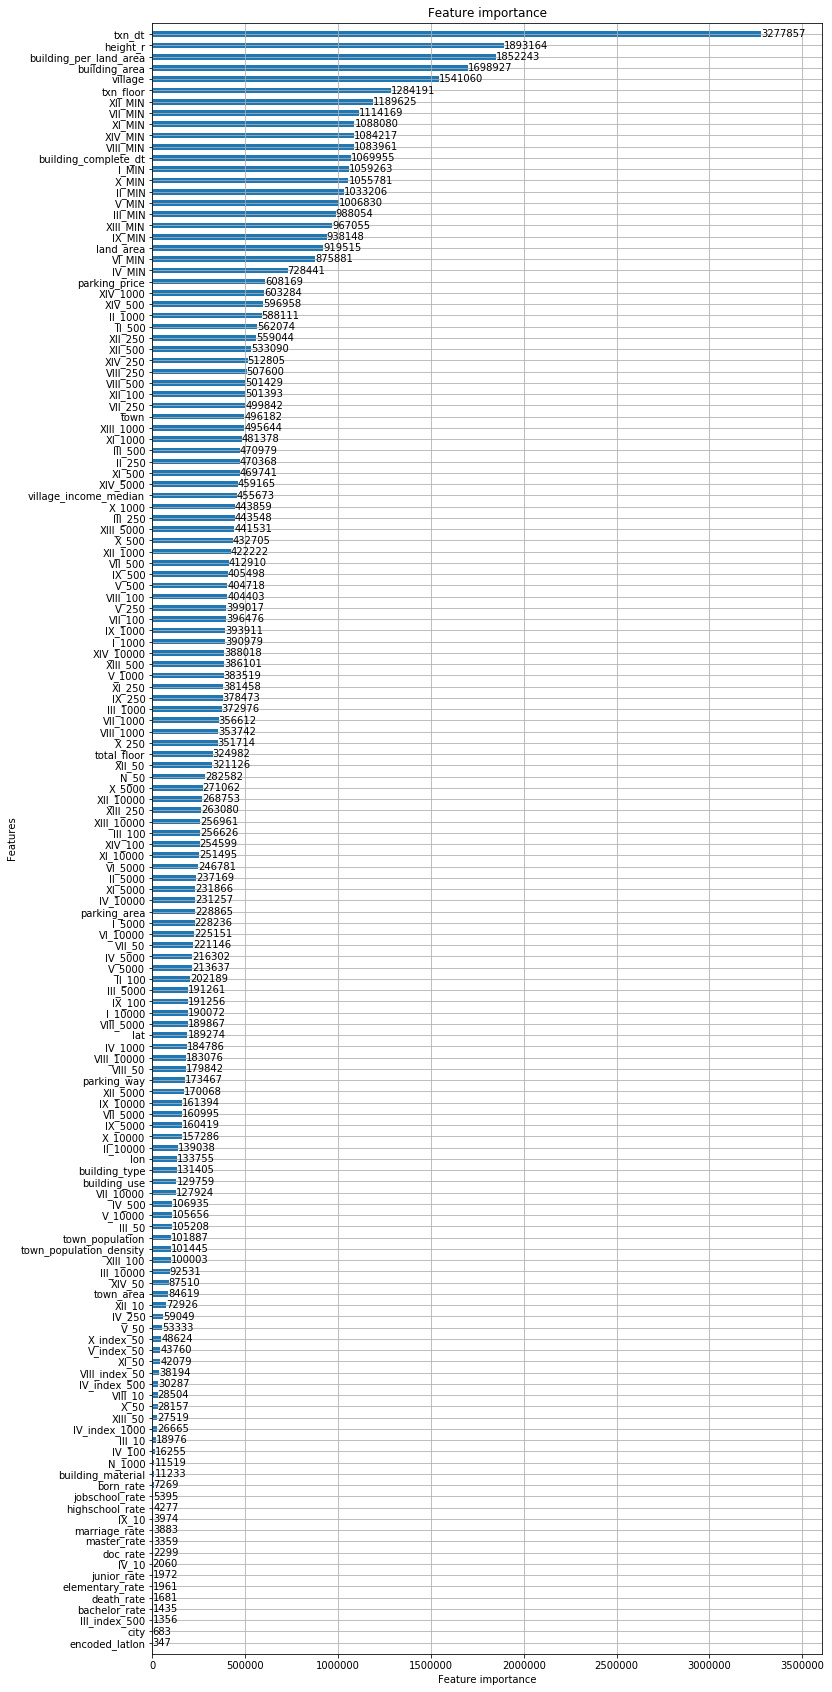

In [35]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5) # 050, 051, 052
plt.show()

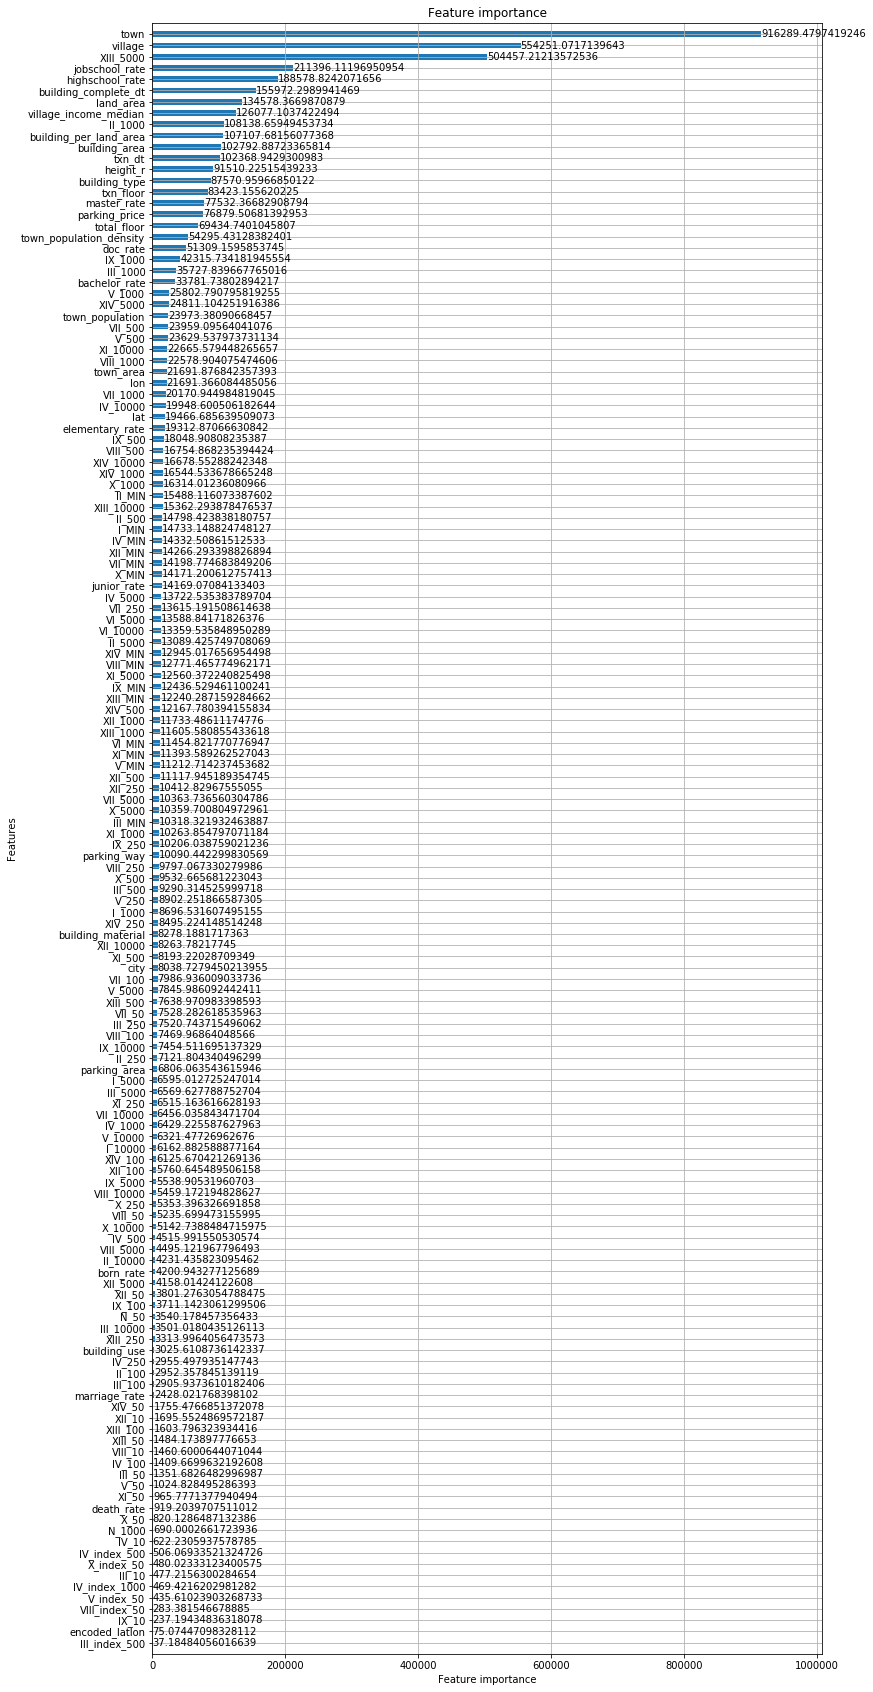

In [36]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5, importance_type='gain') # 050, 051, 052
plt.show()